<a href="https://colab.research.google.com/github/misha345a/E-commerce_Reviews_Classifier/blob/main/Balance_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal
This script is used for cleaning the original Kaggle dataset, as well as preparing both **upsampled** and **text augmented** datasets for model training. <br> These steps are performed seperately because of their lengthy runtimes (i.e. augmentation requires 5hrs+).
<br><br>
Women's E-Commerce Clothing Reviews dataset from Kaggle:
<br>
https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

In [ ]:
%%capture

!pip install opendatasets
!pip install contractions
!pip install autocorrect
!pip install openpyxl -U

In [ ]:
# library imports
import pandas as pd
import opendatasets
import contractions
from autocorrect import Speller
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import nltk
import re

# initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

In [ ]:
# expand notebook display options for dataframes
pd.set_option('display.max_colwidth', 200)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 300

## Load Kaggle Dataset

In [ ]:
# option to directly retrieve the dataset from Kaggle
kaggle_url = 'https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews'
opendatasets.download(kaggle_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: misha345
Your Kaggle Key: ··········


100%|██████████| 2.79M/2.79M [00:00<00:00, 109MB/s]

In [ ]:
# load the dataset 
raw_data = pd.read_csv('/content/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')

In [ ]:
# remove irrelevant columns
dataset = raw_data[['Review Text', 'Recommended IND']]

# remove observations with missing reviews
dataset = dataset[~dataset['Review Text'].isna()]

## Analysis of Target Classes 

In [ ]:
# define observation counts within each class
class_counts = dataset['Recommended IND'].value_counts()

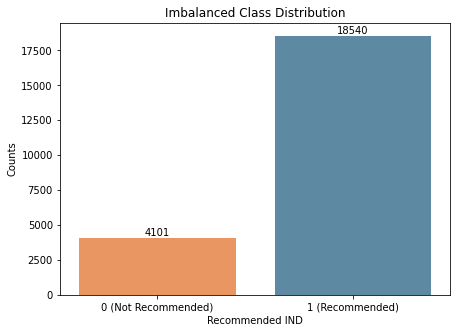

In [ ]:
# display a bar chart of the distribution
plt.figure(figsize = (7, 5))

# define colors
colors = ['#528CAD' if (x < max(class_counts)) else '#FF914D' for x in class_counts]

ax = sns.countplot(x=dataset['Recommended IND'], 
                   data=dataset,
                   palette=colors)
ax.set(title='Imbalanced Class Distribution')

# place labels above each bar
vals = class_counts.to_list()
vals.sort()
ax_labels = vals 
rects = ax.patches
labels = [ax_labels[i] for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

# edit x-tick labels
ax.set_xticklabels(['0 (Not Recommended)', "1 (Recommended)"])

# y-axis label
ax.set_ylabel("Counts")

plt.show()

In [ ]:
# save the chart figure
fig = ax.get_figure()
fig.savefig('Class_Imbalance_BarChart.png', 
            dpi=75, 
            bbox_inches="tight")

## Data Preprocessing
- Lowercase text
- Fix common slang and abbreviations
- Expanding contractions
- Autocorrect misspelled words

In [ ]:
# make all characters uniformly lowercase
dataset['Review Text'] = dataset['Review Text'].apply(lambda x: x.lower())

In [ ]:
def clean_slang(text): 
    """
    Correct common slang and abbreviations.
    """
    text = re.sub(r"\babt?\b", "about", text)
    text = re.sub(r"\bcomfy\b", "comfortable", text)
    text = re.sub(r"\brll?y\b", "really", text)
    text = re.sub(r"\bso{2,}\b", "so", text)
    text = re.sub(r"\bmed\b", "medium", text)
    text = re.sub(r"\bxx?s\b", "extra small", text)
    text = re.sub(r"\bxx?l\b", "extra large", text)
    text = re.sub(r"\bfab\b", "fabulous", text)
    text = re.sub(r"\bblk\b", "black", text)
    text = re.sub(r"\bpromo\b", "promotion", text)
    text = re.sub(r"\btts\b", "true to size", text)
    text = re.sub(r"\blbs?\b", "pounds", text)
    text = re.sub(r"\brn\b", "right now", text)
    text = re.sub(r"\bwanna\b", "want to", text)
    text = re.sub(r"\besp\b", "especially", text)
    text = re.sub(r"\bgonn[ao]\b", "going to", text)
    text = re.sub(r"\btho\b", "though", text)
    text = re.sub(r"altho ", "although ", text)
    text = re.sub(r"prolly", "probably", text)
    text = re.sub(r"asap", "as soon as possible", text)
    text = re.sub(r"\bbc|b/c\b", "because", text)
    text = re.sub(r"\bavail\b", "available", text)
    text = re.sub(r"\bdiff\b", "different", text)
    text = re.sub(r"\bnxt|enxt\b", "next", text)
    text = re.sub(r" w/ ", " with ", text)
    text = re.sub(r"\bdidn ", "didn't ", text)
    text = re.sub(r" dnt ", " don't ", text)
    text = re.sub(r"\bsnd\b", "send", text)
    text = re.sub(r"b4\b", "before", text)
    text = re.sub(r"stink'n", "stinking", text)
    text = re.sub(r"\batm\b", "at the moment", text)
    text = re.sub(r"\besp\b", "especially", text)
    text = re.sub(r"\bavg\b", "average", text)
    text = re.sub(r"(\d'|\d\")\s?(\d+'|\d+\")?", " ", text) # removes height measurements
    text = re.sub(r"'\d+\w+'", " ", text) 
    text = re.sub(r"\s{2,}", " ", text).strip() 

    return text

In [ ]:
dataset['Review Text'] = dataset['Review Text'].progress_apply(clean_slang)

In [ ]:
def cont_expand(text):
    """
    Expand contractions (i.e don't->do not, can't->cannot).
    """
    expanded_text = contractions.fix(text, slang=False)
    return expanded_text

# expand contractions
dataset['Review Text'] = dataset['Review Text'].progress_apply(cont_expand)

In [ ]:
# autocorrect misspelled words (~25 minute runtime)
spell_check = Speller(lang='en')
dataset['Review Text'] = dataset['Review Text'].progress_apply(lambda x: spell_check(str(x)))

In [ ]:
# export to Excel
dataset.to_excel("Raw_Dataset_(Cleaned).xlsx", 
                 header=True, 
                 index=False)

In [ ]:
dataset.sample(5)

## Upsampling (Sklearn)

In [ ]:
from sklearn.utils import resample

# upsample the minority class ('not-recommended') by duplicating random samples
# 1 = recommended
# 0 = not-recommended
upsample = resample(dataset[dataset['Recommended IND']==0],
                    replace=True, # sample with replacement
                    n_samples=16104, # to match majority class
                    random_state=42) # set reproducible results
print(f"Count of 'Not Recommended' examples (after upsampling): {len(upsample)}")

# combine the upsampled minority class with the rest of the data
dataset = pd.concat([dataset[dataset['Recommended IND']!=0], upsample])

Count of 'Not Recommended' examples (after upsampling): 16104


In [ ]:
# export to Excel
dataset.to_excel("Upsampled_Dataset.xlsx", 
                 header=True, 
                 index=False)

## Text Augmentation

1 = Recommended; 18540 values (82%) <br>
0 = Not Recommended; 4101 values (18%) <br>

<br>
There are significantly more "Recommended" observations than "Not-Recommended". Text augmentation is performed to increase the number of minority class examples. Ideally, this will lessen the model's bias towards majority class predictions ("Recommended") during training. Words are randomly swapped, deleted, and substituted with synonyms using a pre-trained word embedding model.  
<br>

<hr>

### Example: 

<u>Original</u>:
<br>
This shirt is very flattering to all due to the adjustable front tie. 
it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!

<u>Augmented Text:</u>
<br>
<b>this design</b> is very flattering <b>to most eyes towards</b> the adjustable <b>rear clasp</b>. 
it was the perfect <b>blouse</b> to wear with leggings <b>because</b> it is sleeveless so it <b>fit</b> well <b>against the dress</b>.
love this <b>stuff</b>!!!


In [ ]:
%%capture

!pip install textattack
!pip install tensorflow_text

In [ ]:
import pandas as pd

from tqdm.notebook import tqdm_notebook
import nltk
import re

# initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

In [ ]:
# load the dataset 
dataset = pd.read_excel('/content/Raw_Dataset_(Cleaned).xlsx')

In [ ]:
# define a dataframe of only negative reviews
df_not_recommend = dataset[dataset['Recommended IND']==0]

In [ ]:
# initialize the augmentation model
from textattack.augmentation import EasyDataAugmenter
aug = EasyDataAugmenter(pct_words_to_swap=0.25, 
                        transformations_per_example=3)

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:49<00:00, 9.79MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpqy4slwth.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


In [ ]:
aug_corpus = []

def augmented_corpus(text):
  """
  Augment text and append to an array.
  """
  try:
    aug_corpus.extend(aug.augment(text))
  except:
    pass

In [ ]:
df_not_recommend['Review Text'].progress_apply(augmented_corpus)

In [ ]:
df_aug_result = pd.DataFrame(zip(aug_corpus, [0]*len(aug_corpus)), 
                             columns=['Review Text', 'Recommended IND'])

# append augmented results to original 'Not Recommended' examples
df_aug_result = df_not_recommend.append(df_aug_result)

In [ ]:
# export to Excel
df_aug_result.to_excel('Augmented_Dataset.xlsx', 
                        header=True, 
                        index=False)

In [ ]:
print(len(df_aug_result))

## Text Augmentation Example

In [ ]:
aug.augment('these pants are beautiful but very sheer and very delicate. \
             not ideal for a mom with kids')